# Development | Implement the different parts and validations of GA

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%matplotlib widget

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jupyter_black

jupyter_black.load()

# Project
from src.data_connectors import read_input_files
from src.data_connectors.read_input_files import Instance

In [3]:
instance = 227
instances_path = "../data/input/HRTInstances"
ins_x = read_input_files.read_file(os.path.join(instances_path, f"Instance_{instance}.txt"))

In [4]:
ins_x.df_setup

,Humans,Robots,WorkingSpaces
0,1,3,3


In [5]:
ins_x.df_resources

,Type,Id
0,H,0
1,R,1
2,R,2
3,R,3


In [6]:
ins_x.df_workingspace_resources

,WorkingSpace,Resource
0,1,1
1,1,0
2,2,2
3,2,0
4,3,3
5,3,0


In [7]:
ins_x.df_workingspace_id.head()

,WorkingSpace,Id
0,1,1
1,1,2
2,1,3
3,1,4
4,1,5


## [Flow](https://miro.com/app/board/uXjVPyl00iw=/)

1. Generate **Initial Population**
2. Verify if order of genes is violating the precedence
    1. Discard those that are violating the precedence
3. Duplicate it for all the jobs in the same instance (SAC)
4. Create the array of times (start and end), using the resources time estimator for the respective mode allocation
5. **Fitness Function**: Compute the total time to complete all the jobs in all working spaces of same instance $\Longrightarrow C$ 
6. **Selection**: Retain the genes with lower C (at maximum X)
    1. Discard those that have larger C
    2. Verify if new population has a significant improvement in total C from previous population.
7. **Generate next population**:
    1. **Crossover**: from survival chromosomes, create offsprings 
    2. **Mutation**: add mutation to the created offsprings (initially larger %, and decreases over time).
8. Return to point **2**.

### 0. The chromosome

```python
chromosome = {
    'mode': [0, 1, 2, 2, 1, ... ], # resource ID
    'order': [2, 3, 1, 4, 5, ...], # order of tasks of each position
    }

```

In [8]:
from src.genetic_algorithm.chromosome import Chromosome

### 1. Generate initial population

By default, it generates population for 1 working space:

**Note**:
- *It is important to generate a large first population, because a lot chromosomes might not survived due to feasibility of solutions.*

In [9]:
from src.genetic_algorithm import first_population

# Modes
possible_modes = first_population.get_possible_modes(ins_x)

# Tasks
n_tasks = first_population.get_total_number_of_tasks_per_working_space(ins_x)

# Chromosomes
chromosomes = first_population.get_first_population(ins_x, possible_modes, n_tasks)

In [13]:
chromosomes[0]

Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [14]:
# tasks of first job
first_working_space = ins_x.df_workingspace_id.WorkingSpace.min()
list_tasks_ws1 = ins_x.df_workingspace_id[
    ins_x.df_workingspace_id.WorkingSpace == first_working_space
].Id.unique()
list_tasks_ws1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [17]:
list_tasks_ws1_with_successors = ins_x.df_predecessor_sucessor[
    ins_x.df_predecessor_sucessor.Predecessor.isin(list_tasks_ws1)
].Predecessor.unique()
list_tasks_ws1_with_successors

array([ 1,  2,  3,  4,  5,  8,  9, 10, 11,  6,  7, 12, 15, 13, 14, 20, 25,
       27, 18, 26, 17, 36, 16, 31, 40, 37, 22, 34])

In [19]:
list_tasks_ws1_without_successors = np.array(
    [task for task in list_tasks_ws1 if task not in list_tasks_ws1_with_successors]
)
list_tasks_ws1_without_successors

array([19, 21, 23, 24, 28, 29, 30, 32, 33, 35, 38, 39, 41, 42, 43, 44, 45,
       46, 47, 48, 49, 50])

In [45]:
from itertools import cycle, islice

input = [1, 2, 3, 4]
output = list(islice(cycle(input), 10))
output

[1, 2, 3, 4, 1, 2, 3, 4, 1, 2]

In [42]:
import itertools


def regroup_permutations(
    permutations_of_oders: list[list[tuple[int]]],
) -> list[list[int]]:
    result = []
    for i in range(len(permutations_of_oders[0])):
        temp = []
        for j in range(len(permutations_of_oders)):
            if i < len(permutations_of_oders[j]):
                temp.extend(list(permutations_of_oders[j][i]))
            else:
                temp.extend(list())
        result.append(temp)
    return result


def get_permutations_for_specific_tasks(
    tasks: list[int],
) -> list[list[int]]:
    n_elements_to_permute = 5
    orders_sections = [
        tasks[i : i + n_elements_to_permute] for i in range(0, len(tasks), n_elements_to_permute)
    ]
    # print("orders_sections", orders_sections

    permutations_of_oders = [
        list(itertools.permutations(order_section)) for order_section in orders_sections
    ]
    base_len = len(permutations_of_oders[0])
    normalised_permutations_of_oders = []
    for permut in permutations_of_oders:
        if len(permut) < base_len:
            permut = list(islice(cycle(permut), base_len))
        normalised_permutations_of_oders.append(permut)

    print("permutations_of_oders", permutations_of_oders)

    order_permutations = regroup_permutations(permutations_of_oders)
    return order_permutations


def get_precedence_aware_order(instance: Instance) -> list[list[str]]:
    first_working_space = instance.df_workingspace_id.WorkingSpace.min()
    list_tasks_ws1 = instance.df_workingspace_id[
        instance.df_workingspace_id.WorkingSpace == first_working_space
    ].Id.unique()
    list_tasks_ws1_with_successors = instance.df_predecessor_sucessor[
        instance.df_predecessor_sucessor.Predecessor.isin(list_tasks_ws1)
    ].Predecessor.unique()
    # print("list_tasks_ws1_with_successors", list_tasks_ws1_with_successors)

    permutations_on_predecessor_tasks = get_permutations_for_specific_tasks(
        list_tasks_ws1_with_successors
    )

    list_tasks_ws1_without_successors = np.array(
        [task for task in list_tasks_ws1 if task not in list_tasks_ws1_with_successors]
    )
    permutations_on_no_predecessor_tasks = get_permutations_for_specific_tasks(
        list_tasks_ws1_without_successors
    )
    overal_permutations = []
    for w_pred in permutations_on_predecessor_tasks:
        for wout_pred in permutations_on_no_predecessor_tasks:
            overal_permutations.append(w_pred + wout_pred)
    return overal_permutations

In [43]:
overal_permutations_precedence_aware = get_precedence_aware_order(ins_x)

permutations_of_oders [[(1, 2, 3, 4, 5), (1, 2, 3, 5, 4), (1, 2, 4, 3, 5), (1, 2, 4, 5, 3), (1, 2, 5, 3, 4), (1, 2, 5, 4, 3), (1, 3, 2, 4, 5), (1, 3, 2, 5, 4), (1, 3, 4, 2, 5), (1, 3, 4, 5, 2), (1, 3, 5, 2, 4), (1, 3, 5, 4, 2), (1, 4, 2, 3, 5), (1, 4, 2, 5, 3), (1, 4, 3, 2, 5), (1, 4, 3, 5, 2), (1, 4, 5, 2, 3), (1, 4, 5, 3, 2), (1, 5, 2, 3, 4), (1, 5, 2, 4, 3), (1, 5, 3, 2, 4), (1, 5, 3, 4, 2), (1, 5, 4, 2, 3), (1, 5, 4, 3, 2), (2, 1, 3, 4, 5), (2, 1, 3, 5, 4), (2, 1, 4, 3, 5), (2, 1, 4, 5, 3), (2, 1, 5, 3, 4), (2, 1, 5, 4, 3), (2, 3, 1, 4, 5), (2, 3, 1, 5, 4), (2, 3, 4, 1, 5), (2, 3, 4, 5, 1), (2, 3, 5, 1, 4), (2, 3, 5, 4, 1), (2, 4, 1, 3, 5), (2, 4, 1, 5, 3), (2, 4, 3, 1, 5), (2, 4, 3, 5, 1), (2, 4, 5, 1, 3), (2, 4, 5, 3, 1), (2, 5, 1, 3, 4), (2, 5, 1, 4, 3), (2, 5, 3, 1, 4), (2, 5, 3, 4, 1), (2, 5, 4, 1, 3), (2, 5, 4, 3, 1), (3, 1, 2, 4, 5), (3, 1, 2, 5, 4), (3, 1, 4, 2, 5), (3, 1, 4, 5, 2), (3, 1, 5, 2, 4), (3, 1, 5, 4, 2), (3, 2, 1, 4, 5), (3, 2, 1, 5, 4), (3, 2, 4, 1, 5), (3, 2, 

In [41]:
overal_permutations_precedence_aware[0]

[1,
 2,
 3,
 4,
 5,
 1,
 2,
 3,
 5,
 4,
 1,
 2,
 4,
 3,
 5,
 1,
 2,
 4,
 5,
 3,
 1,
 2,
 5,
 3,
 4,
 1,
 2,
 5,
 4,
 3,
 1,
 3,
 2,
 4,
 5,
 1,
 3,
 2,
 5,
 4,
 1,
 3,
 4,
 2,
 5,
 1,
 3,
 4,
 5,
 2,
 1,
 3,
 5,
 2,
 4,
 1,
 3,
 5,
 4,
 2,
 1,
 4,
 2,
 3,
 5,
 1,
 4,
 2,
 5,
 3,
 1,
 4,
 3,
 2,
 5,
 1,
 4,
 3,
 5,
 2,
 1,
 4,
 5,
 2,
 3,
 1,
 4,
 5,
 3,
 2,
 1,
 5,
 2,
 3,
 4,
 1,
 5,
 2,
 4,
 3,
 1,
 5,
 3,
 2,
 4,
 1,
 5,
 3,
 4,
 2,
 1,
 5,
 4,
 2,
 3,
 1,
 5,
 4,
 3,
 2,
 2,
 1,
 3,
 4,
 5,
 2,
 1,
 3,
 5,
 4,
 2,
 1,
 4,
 3,
 5,
 2,
 1,
 4,
 5,
 3,
 2,
 1,
 5,
 3,
 4,
 2,
 1,
 5,
 4,
 3,
 2,
 3,
 1,
 4,
 5,
 2,
 3,
 1,
 5,
 4,
 2,
 3,
 4,
 1,
 5,
 2,
 3,
 4,
 5,
 1,
 2,
 3,
 5,
 1,
 4,
 2,
 3,
 5,
 4,
 1,
 2,
 4,
 1,
 3,
 5,
 2,
 4,
 1,
 5,
 3,
 2,
 4,
 3,
 1,
 5,
 2,
 4,
 3,
 5,
 1,
 2,
 4,
 5,
 1,
 3,
 2,
 4,
 5,
 3,
 1,
 2,
 5,
 1,
 3,
 4,
 2,
 5,
 1,
 4,
 3,
 2,
 5,
 3,
 1,
 4,
 2,
 5,
 3,
 4,
 1,
 2,
 5,
 4,
 1,
 3,
 2,
 5,
 4,
 3,
 1,
 3,
 1,
 2,
 4,
 5,
 3,
 1,
 2,
 5,
 4,


### 2. Verify feasibility of solutions

We need to verify:
- the precedence is valid
- the combination of modes and tasks is possible (the selected mode can perform the associated task) 

In [10]:
from src.genetic_algorithm import feasibility

In [11]:
ins_x.df_predecessor_sucessor.head()

,Predecessor,Sucessor
0,1,2
1,2,3
2,3,4
3,1,4
4,1,5


In [12]:
precedence_feasible_chromosomes = []
for i in range(len(chromosomes)):
    chrom = chromosomes[i]
    if feasibility.is_chromosome_precedence_feasible(ins_x, chrom):
        precedence_feasible_chromosomes.append(chrom)

print(f"From {len(chromosomes)} to {len(precedence_feasible_chromosomes)}")

From 12960 to 216


In [13]:
task_mode_feasible_chromosomes = []
for i in range(len(precedence_feasible_chromosomes)):
    chrom = precedence_feasible_chromosomes[i]
    if feasibility.is_chromosome_task_mode_feasible(ins_x, chrom):
        task_mode_feasible_chromosomes.append(chrom)

print(f"From {len(precedence_feasible_chromosomes)} to {len(task_mode_feasible_chromosomes)}")

From 216 to 216


### 3. Increment duplication with possible extra working spaces

1. e.g. if other working spaces exist, duplicate the working modes, and duplicate the orders

In [14]:
from src.genetic_algorithm import replication

In [15]:
# Generate new orders
chromosome = task_mode_feasible_chromosomes[0]
chromosome

Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [16]:
chromosome_with_replication = replication.update_chromosome_with_replication(ins_x, chromosome)

In [17]:
chromosome_with_replication

Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59])

In [18]:
# for all feasible chromosomes
replicated_chromosomes = []
for chromosome in task_mode_feasible_chromosomes:
    replicated_chromosomes.append(replication.update_chromosome_with_replication(ins_x, chromosome))

len(replicated_chromosomes)

216

In [19]:
replicated_chromosomes[:10]

[Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55, 58, 2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56, 59]),
 Chromosome(mode=['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'], order=[0, 3, 6, 12, 9, 15, 18, 21, 27, 24, 30, 33, 36, 42, 39, 45, 48, 51, 57, 54, 1, 4, 7, 13, 10, 16, 19, 22, 28, 25, 31,

### 4. Get notion of start and end times

1. Go task by task, and get the start and end time, based on allocation of current mode, and based on precedence
2. Compute total timespan - which is the maximum value of endtimes

In [20]:
from src.genetic_algorithm import time_allocation

In [21]:
# for all replicated chromosomes
time_allocated_chromosomes = []
for chromosome in replicated_chromosomes:
    time_allocated_chromosomes.append(time_allocation.get_all_time_allocations(ins_x, chromosome))

len(time_allocated_chromosomes)

216

In [22]:
# for all results
makespan_all_chromosomes = []
for chromosome_time_allocation in time_allocated_chromosomes:
    makespan_all_chromosomes.append(time_allocation.find_makespan(chromosome_time_allocation))

len(makespan_all_chromosomes)

216

In [23]:
min(makespan_all_chromosomes)

1212

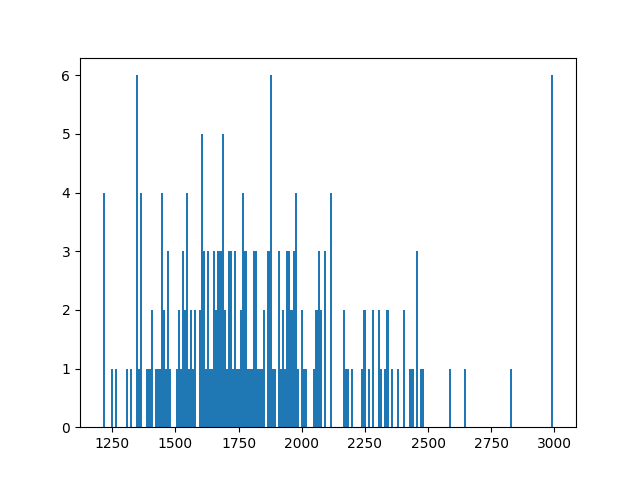

In [24]:
plt.figure()
plt.hist(makespan_all_chromosomes, bins=len(makespan_all_chromosomes))
plt.show()

### 5. Keep fittest chromosomes 

Let's keep the best 100

In [25]:
from src.genetic_algorithm import fitness

In [26]:
fittest_chromosomes, fittest_makespan = fitness.keep_fittest_n_chromosomes(
    task_mode_feasible_chromosomes, makespan_all_chromosomes, 100
)
len(fittest_chromosomes)

101

### 6. Is new population better than previous one?

In [27]:
# if this is the first population
previous_population_makespan = None
this_population_makespan = fittest_chromosomes

should_we_continue = fitness.is_this_population_better_than_previous_one(
    previous_population_makespan, this_population_makespan
)
print(f"Should we continue iterating? {should_we_continue}")

Should we continue iterating? True


### 7. Generate next population

with: 
1. Crossover
2. Mutation

In [28]:
from src.genetic_algorithm import next_population

#### 7.1. Crossover

- **One-Point Crossover**:
    1. select a random crossover point along the length of the chromosomes 
    2. split into 2 proportions on that point, and swapp them between the two parent chromosomes to generate the 2 offsprings.

- **Two-Point Crossover**: similar to one-point crossover, but with two crossover points.

- **Uniform Crossover**: 
    1. Given a probability, select points from each parent and populate for the offsprings.

- **Arithmetic Crossover** is not possible given the current experiment.


In [29]:
new_generation = next_population.generate_next_population_with_crossover(
    fittest_chromosomes, fittest_makespan
)

In [30]:
len(new_generation)

200

#### 7.2. Mutation

Swap mutation: This technique randomly selects two genes within a chromosome and swaps their positions.

Scramble mutation: This technique randomly selects a subset of genes within a chromosome and shuffles their order.

Inversion mutation: This technique randomly selects a subset of genes within a chromosome and reverses their order.

In [31]:
new_mutated_population = []
probability = 0.4
for chromosome in new_generation:
    new_mutated_population.append(
        next_population.swap_mutation_at_probability(chromosome, probability)
    )